## Import Libraries

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
import pymc as pm
import arviz as az
from sklearn.metrics import root_mean_squared_error, mean_absolute_error
import warnings
warnings.filterwarnings('ignore')

## Load Data

In [6]:
# Folder name
folder = 'Data'

# Read each file
artists = pd.read_csv(f'{folder}/artists.dat', sep='\t')
tags = pd.read_csv(f'{folder}/tags.dat', sep='\t', encoding='latin-1')
user_artists = pd.read_csv(f'{folder}/user_artists.dat', sep='\t')
user_friends = pd.read_csv(f'{folder}/user_friends.dat', sep='\t')
user_taggedartists = pd.read_csv(f'{folder}/user_taggedartists.dat', sep='\t')
user_taggedartists_timestamps = pd.read_csv(f'{folder}/user_taggedartists-timestamps.dat', sep='\t')


In [7]:
artists.head()

,id,name,url,pictureURL
0,1,MALICE MIZER,http://www.last.fm/music/MALICE+MIZER,http://userserve-ak.last.fm/serve/252/10808.jpg
1,2,Diary of Dreams,http://www.last.fm/music/Diary+of+Dreams,http://userserve-ak.last.fm/serve/252/3052066.jpg
2,3,Carpathian Forest,http://www.last.fm/music/Carpathian+Forest,http://userserve-ak.last.fm/serve/252/40222717...
3,4,Moi dix Mois,http://www.last.fm/music/Moi+dix+Mois,http://userserve-ak.last.fm/serve/252/54697835...
4,5,Bella Morte,http://www.last.fm/music/Bella+Morte,http://userserve-ak.last.fm/serve/252/14789013...


In [8]:
tags.head()

,tagID,tagValue
0,1,metal
1,2,alternative metal
2,3,goth rock
3,4,black metal
4,5,death metal


In [9]:
user_artists.head()

,userID,artistID,weight
0,2,51,13883
1,2,52,11690
2,2,53,11351
3,2,54,10300
4,2,55,8983


In [10]:
user_friends.head()

,userID,friendID
0,2,275
1,2,428
2,2,515
3,2,761
4,2,831


In [11]:
user_taggedartists.head()

,userID,artistID,tagID,day,month,year
0,2,52,13,1,4,2009
1,2,52,15,1,4,2009
2,2,52,18,1,4,2009
3,2,52,21,1,4,2009
4,2,52,41,1,4,2009


In [12]:
user_taggedartists_timestamps.head()

,userID,artistID,tagID,timestamp
0,2,52,13,1238536800000
1,2,52,15,1238536800000
2,2,52,18,1238536800000
3,2,52,21,1238536800000
4,2,52,41,1238536800000


## EDA

In [13]:
# Merge user_artists with artists
ua_artists = pd.merge(user_artists, artists, left_on='artistID', right_on='id', how='left')

# Merge user_taggedartists with tags and artists
uta_tags = pd.merge(user_taggedartists, tags, left_on='tagID', right_on='tagID', how='left')
uta_full = pd.merge(uta_tags, artists, left_on='artistID', right_on='id', how='left')

ua_artists.head()

,userID,artistID,weight,id,name,url,pictureURL
0,2,51,13883,51,Duran Duran,http://www.last.fm/music/Duran+Duran,http://userserve-ak.last.fm/serve/252/155668.jpg
1,2,52,11690,52,Morcheeba,http://www.last.fm/music/Morcheeba,http://userserve-ak.last.fm/serve/252/46005111...
2,2,53,11351,53,Air,http://www.last.fm/music/Air,http://userserve-ak.last.fm/serve/252/251119.jpg
3,2,54,10300,54,Hooverphonic,http://www.last.fm/music/Hooverphonic,http://userserve-ak.last.fm/serve/252/40553471...
4,2,55,8983,55,Kylie Minogue,http://www.last.fm/music/Kylie+Minogue,http://userserve-ak.last.fm/serve/252/12740835...


In [14]:
uta_tags.head()

,userID,artistID,tagID,day,month,year,tagValue
0,2,52,13,1,4,2009,chillout
1,2,52,15,1,4,2009,downtempo
2,2,52,18,1,4,2009,electronic
3,2,52,21,1,4,2009,trip-hop
4,2,52,41,1,4,2009,female vovalists


In [15]:
uta_full.head()

,userID,artistID,tagID,day,month,year,tagValue,id,name,url,pictureURL
0,2,52,13,1,4,2009,chillout,52.0,Morcheeba,http://www.last.fm/music/Morcheeba,http://userserve-ak.last.fm/serve/252/46005111...
1,2,52,15,1,4,2009,downtempo,52.0,Morcheeba,http://www.last.fm/music/Morcheeba,http://userserve-ak.last.fm/serve/252/46005111...
2,2,52,18,1,4,2009,electronic,52.0,Morcheeba,http://www.last.fm/music/Morcheeba,http://userserve-ak.last.fm/serve/252/46005111...
3,2,52,21,1,4,2009,trip-hop,52.0,Morcheeba,http://www.last.fm/music/Morcheeba,http://userserve-ak.last.fm/serve/252/46005111...
4,2,52,41,1,4,2009,female vovalists,52.0,Morcheeba,http://www.last.fm/music/Morcheeba,http://userserve-ak.last.fm/serve/252/46005111...


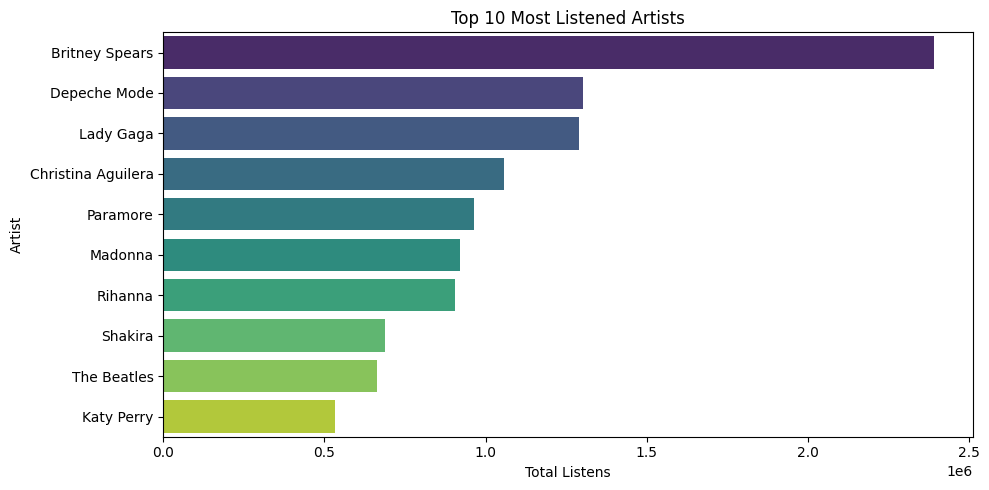

In [16]:
top_artists = ua_artists.groupby('name')['weight'].sum().sort_values(ascending=False).head(10)

plt.figure(figsize=(10,5))
sns.barplot(x=top_artists.values, y=top_artists.index, palette='viridis')
plt.title('Top 10 Most Listened Artists')
plt.xlabel('Total Listens')
plt.ylabel('Artist')
plt.tight_layout()
plt.show()

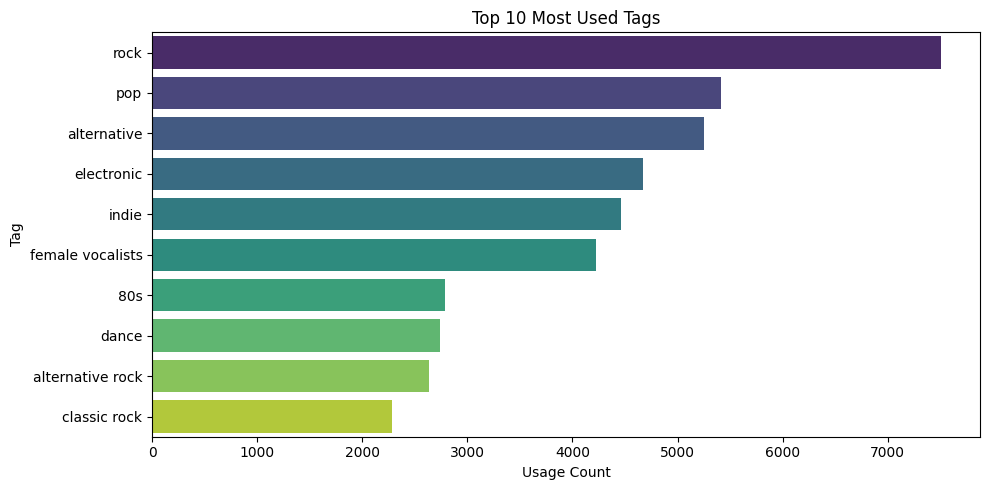

In [17]:
top_tags = uta_full['tagValue'].value_counts().head(10)

plt.figure(figsize=(10,5))
sns.barplot(x=top_tags.values, y=top_tags.index, palette='viridis')
plt.title('Top 10 Most Used Tags')
plt.xlabel('Usage Count')
plt.ylabel('Tag')
plt.tight_layout()
plt.show()

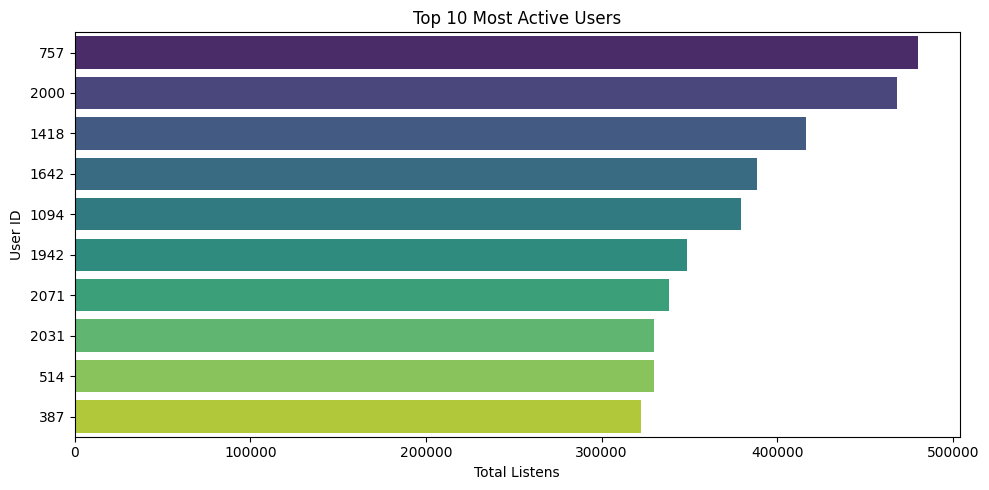

In [18]:
user_activity = ua_artists.groupby('userID')['weight'].sum().sort_values(ascending=False).head(10)

plt.figure(figsize=(10,5))
sns.barplot(x=user_activity.values, y=user_activity.index.astype(str), palette='viridis')
plt.title('Top 10 Most Active Users')
plt.xlabel('Total Listens')
plt.ylabel('User ID')
plt.tight_layout()
plt.show()

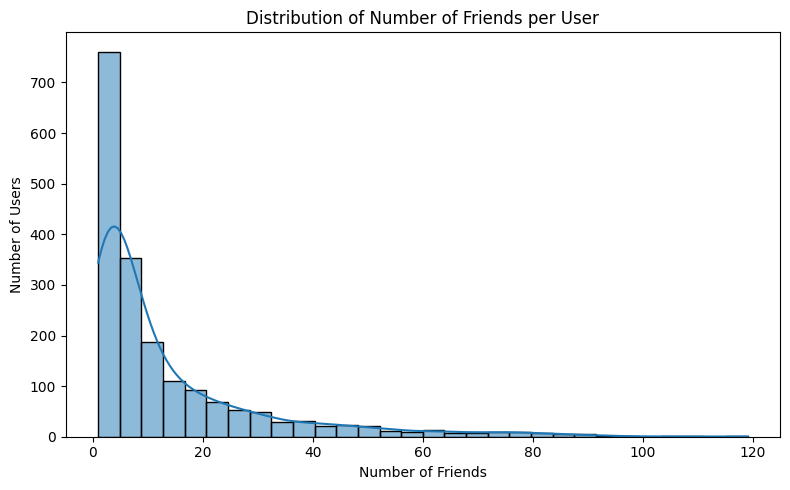

In [19]:
friend_counts = user_friends['userID'].value_counts()

plt.figure(figsize=(8,5))
sns.histplot(friend_counts, bins=30, kde=True)
plt.title('Distribution of Number of Friends per User')
plt.xlabel('Number of Friends')
plt.ylabel('Number of Users')
plt.tight_layout()
plt.show()


## Modeling

### Data prep

In [20]:
# Map user and artist IDs to indices
user_ids = user_artists['userID'].unique()
artist_ids = user_artists['artistID'].unique()
user_map = {u: i for i, u in enumerate(user_ids)}
artist_map = {a: i for i, a in enumerate(artist_ids)}

# Create index columns
user_artists['user_idx'] = user_artists['userID'].map(user_map)
user_artists['artist_idx'] = user_artists['artistID'].map(artist_map)

# Log-transform the weights to reduce skew
user_artists['log_weight'] = np.log1p(user_artists['weight'])

# Prepare arrays for modeling
user_idx = user_artists['user_idx'].values
artist_idx = user_artists['artist_idx'].values
ratings = user_artists['log_weight'].values

### Train Test split

In [21]:
# Split indices for train/test
train_idx, test_idx = train_test_split(
    np.arange(len(ratings)), test_size=0.2, random_state=42
)

# Training data
train_user_idx = user_idx[train_idx]
train_artist_idx = artist_idx[train_idx]
train_ratings = ratings[train_idx]

# Test data
test_user_idx = user_idx[test_idx]
test_artist_idx = artist_idx[test_idx]
test_ratings = ratings[test_idx]

### Build and Fit Bayesian Probabalistic Matrix Factorization (BPMF) model

In [25]:
num_users = len(user_ids)
num_items = len(artist_ids)
K = 5  # Latent dimension

with pm.Model() as bpmf:
    # Hyperpriors
    mu_u = pm.Normal('mu_u', mu=0, sigma=1, shape=K)
    mu_v = pm.Normal('mu_v', mu=0, sigma=1, shape=K)
    sigma_u = pm.HalfNormal('sigma_u', sigma=1)
    sigma_v = pm.HalfNormal('sigma_v', sigma=1)

    # Latent factors
    U = pm.Normal('U', mu=mu_u, sigma=sigma_u, shape=(num_users, K))
    V = pm.Normal('V', mu=mu_v, sigma=sigma_v, shape=(num_items, K))

    # Predicted ratings for training data
    dot_product = (U[train_user_idx] * V[train_artist_idx]).sum(axis=1)

    # Observation noise
    sigma = pm.HalfNormal('sigma', sigma=1)

    # Likelihood
    R_obs = pm.Normal('R_obs', mu=dot_product, sigma=sigma, observed=train_ratings)

    # Run Markov Chain Monte Carlo (MCMC) sampling on BPMF model
    # 1000 samples from posterior, 2000 tuning steps, 90% acceptance rate
    # trace = pm.sample(draws=1000, tune=2000, chains=4, target_accept=0.95, cores=4, return_inferencedata=True)

    # ---- ADVI INFERENCE ----
    # Fit the model using ADVI (variational inference)
    approx = pm.fit(n=20000, method='advi')  # n can be increased for more accuracy

    # Draw posterior samples from the variational approximation
    trace = approx.sample(1000)


Output()

Finished [100%]: Average Loss = 1.4107e+05


### Check divergences, convergence, and summary table of posterior statistics

arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
sigma,1.445,0.035,1.378,1.511,0.001,0.001,1101.0,816.0,NaN
"U[0, 0]",1.621,0.222,1.197,2.040,0.007,0.005,899.0,941.0,NaN
"U[0, 1]",-0.826,0.251,-1.250,-0.327,0.008,0.006,1049.0,984.0,NaN
"U[0, 2]",-1.813,0.204,-2.220,-1.450,0.007,0.005,851.0,929.0,NaN
"U[0, 3]",1.326,0.235,0.910,1.768,0.008,0.005,932.0,878.0,NaN
...,...,...,...,...,...,...,...,...,...
"V[17631, 0]",1.003,0.931,-0.624,2.791,0.030,0.022,976.0,979.0,NaN
"V[17631, 1]",-0.657,0.925,-2.540,0.941,0.030,0.021,945.0,975.0,NaN
"V[17631, 2]",-1.090,0.955,-2.892,0.640,0.034,0.022,777.0,898.0,NaN
"V[17631, 3]",0.899,0.940,-0.783,2.694,0.029,0.022,1048.0,981.0,NaN


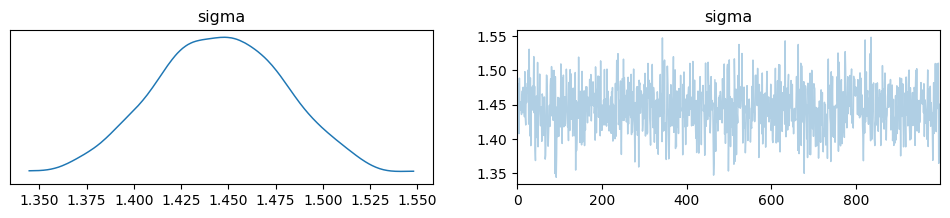

In [27]:
# print("Divergences:", trace.sample_stats['diverging'].sum().values)
az.plot_trace(trace, var_names=['sigma'])
az.summary(trace, var_names=['sigma','U','V'])

### Predict on Test Set and Calc Error Metrics

In [28]:
# Use posterior means for prediction
posterior_U = trace.posterior['U'].mean(dim=("chain", "draw")).values
posterior_V = trace.posterior['V'].mean(dim=("chain", "draw")).values

# Predict test ratings
test_pred_ratings = (posterior_U[test_user_idx] * posterior_V[test_artist_idx]).sum(axis=1)

# Compute error metrics
rmse = root_mean_squared_error(test_ratings, test_pred_ratings)
mae = mean_absolute_error(test_ratings, test_pred_ratings)

print(f"Test RMSE: {rmse:.4f}")
print(f"Test MAE: {mae:.4f}")

Test RMSE: 0.9349
Test MAE: 0.6986


### Visualize Posterior Predictive Checks

In [ ]:
plt.figure(figsize=(7, 7))
plt.scatter(test_ratings, test_pred_ratings, alpha=0.2)
plt.plot([test_ratings.min(), test_ratings.max()], [test_ratings.min(), test_ratings.max()], 'r--')
plt.xlabel('True log(listen count)')
plt.ylabel('Predicted log(listen count)')
plt.title('BPMF Predictions vs. True Values (Test Set)')
plt.show()